In [1]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# surpress warnings
import warnings
warnings.filterwarnings('ignore')


# Question 2

We assume that the daily change viewCount corresponds to the number of viewers of a song. The number of viewers each day also changes from date to date. To calculate these, we wrote methods additional to the ones we had written in question 1. These methods are:
- get_view_growth: Used to calculate the increase in view growth each date. This increase represents the number of viewers
- get_z_hat_df: For a day t, let the number of viewers be z. Than the number of viewers next day is z. This method is used to generate all the (z,z) pairs.
- apply_p: This method is used to draw the fitted polynomial by applying the polynomial represented by its coefficients to a series of points


In [2]:
def get_files(folder):
    directory = "data/%s/" % folder
    return glob.glob(directory + "*.json")

def load_dict(file):
    d = None
    with open(file.replace("\\", "/")) as file:
        d = json.load(file)
    return d

def load_df(folder):

    files = get_files(folder)
    get_date = lambda file_name: file_name[len(folder) + 6:-15]

    if folder in ["youtube_top100", "radio3fm_megahit", "radio538_alarmschijf"]:

        keys = ['viewCount',
                'likeCount',
                'dislikeCount',
                'commentCount',
                #'favoriteCount'
                ]
                
        df = []
        for year_file in files:
            year_data = load_dict(year_file)
            for song_data in year_data:
                row = [get_date(year_file), song_data['snippet']['title']]
                row.extend([song_data['statistics'][key] for key in keys])
                df.append(row)

        columns = ['date', 'songName']
        columns.extend(keys)
        df = pd.DataFrame(df, columns = columns)

        for column in set(df.columns).difference({'date', 'songName'}):
            df[column] = df[column].astype('double')

        df['likeDislikeDiff']  = df['likeCount'] - df['dislikeCount']
        df['likeDislikeTotal'] = df['likeCount'] + df['dislikeCount']

        df.index = pd.to_datetime(df['date'], format='%Y%m%d')
            
        return df
    if folder == "spotify_top100":        

        # missing artist name

        keys = ['name',
                'popularity']

        df = []
        for year_file in files:
            year_data = load_dict(year_file)
            for track_data in year_data['tracks']['items']:
                row = [get_date(year_file)]
                row.extend(track_data['track'][key] for key in keys)
                df.append(row)
        
        columns = ['date']
        columns.extend(keys)
        df = pd.DataFrame(df, columns = columns)
        
        df.index = pd.to_datetime(df['date'], format='%Y%m%d')

        return df
    else:
        raise AssertionError("Function not implemented for the folder \"%s\"" % folder)

def get_song_dfs(df, n=None, seed=37):
    """Get a list of dataframes. Each dataframe represents one song

    Create the dataframe with the song name and then interpolate to fill
    empty dates

    Args:
        df (DataFrame): Original dataframe. Should be created from Youtube format
        n (int): Number of song dfs to create and return. Default value in None,
            all the possible songs are used to create song dfs when n is None.
    """
    np.random.seed(seed)

    songs = df['songName'].unique()
    if n:
        songs = np.random.choice(songs, n)
    song_dfs = []
    for song_name in songs:
        song_df = df[df['songName'] == song_name]
        song_df = song_df.resample('D').asfreq()
        song_df = song_df.interpolate()
        song_dfs.append(song_df)
    return song_dfs

get_line_method = lambda p: lambda x: p[0] * x + p[1]

def get_view_growth(viewCount):
    return (viewCount.shift(-1) - viewCount).dropna()

def get_z_hat_df(series):
    df = pd.DataFrame({'z':series, 'z_hat':series.shift(-1)})
    df = df.dropna()
    return df

def apply_p(p, series):
    l = len(p)
    sum = (series ** (l-1)) * p[0]
    for i in range(l-1):
        sum += (series ** (l-i-2)) * p [i+1]
    return sum

We first load the Youtube data:

In [3]:
youtube_df = load_df("youtube_top100")
youtube_df

,date,songName,viewCount,likeCount,dislikeCount,commentCount,likeDislikeDiff,likeDislikeTotal
date,,,,,,,,
2015-11-09,20151109,Adele - Hello,297130779.0,4093202.0,101335.0,291458.0,3991867.0,4194537.0
2015-11-09,20151109,Justin Bieber - Sorry (Dance Video),92743480.0,1355977.0,71243.0,104720.0,1284734.0,1427220.0
2015-11-09,20151109,Drake - Hotline Bling,57075104.0,672355.0,60531.0,72120.0,611824.0,732886.0
2015-11-09,20151109,Justin Bieber - What Do You Mean?,276365510.0,2310400.0,254413.0,189319.0,2055987.0,2564813.0
2015-11-09,20151109,Shawn Mendes - Stitches (Official Video),72148555.0,906781.0,14618.0,57624.0,892163.0,921399.0
...,...,...,...,...,...,...,...,...
2016-11-28,20161128,Flo Rida - My House [Official Video],177568317.0,965907.0,37839.0,47163.0,928068.0,1003746.0
2016-11-28,20161128,Drake - Right Hand Girl dance vine,700870.0,7521.0,256.0,457.0,7265.0,7777.0
2016-11-28,20161128,Rihanna - Bitch Better Have My Money (Explicit),100217083.0,1590438.0,192198.0,128521.0,1398240.0,1782636.0


Then we plot the view counts of some of the songs over time.

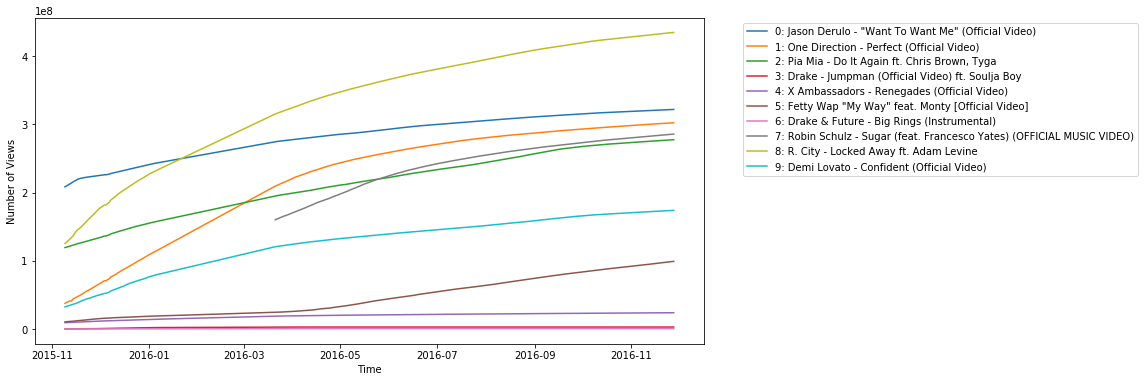

In [4]:
plt.figure(figsize=(12,6))
n, seed = 10,2
song_dfs = get_song_dfs(youtube_df, n = n, seed = seed)
for i, song_df in enumerate(song_dfs):
    plt.plot(song_df.index, song_df['viewCount'], label="%d: %s"%(i, song_df.iloc[0]['songName']))
plt.xlabel("Time")
plt.ylabel("Number of Views")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

We also plot the increase in view counts in a log scale because we will use it in question 3. 

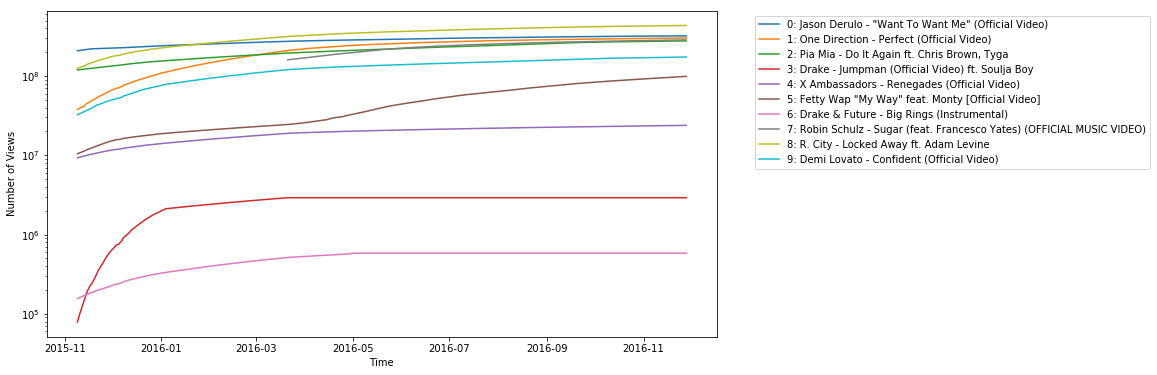

In [10]:
plt.figure(figsize=(12,6))
n, seed = 10,2
song_dfs = get_song_dfs(youtube_df, n = n, seed = seed)
for i, song_df in enumerate(song_dfs):
    plt.plot(song_df.index, song_df['viewCount'], label="%d: %s"%(i, song_df.iloc[0]['songName']))
plt.xlabel("Time")
plt.ylabel("Number of Views")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.yscale('log')
plt.show()

We then start working on the daily change in daily growth. We do this by generating a dataframe using get_z_hat_df method and plotting the resulting data points.

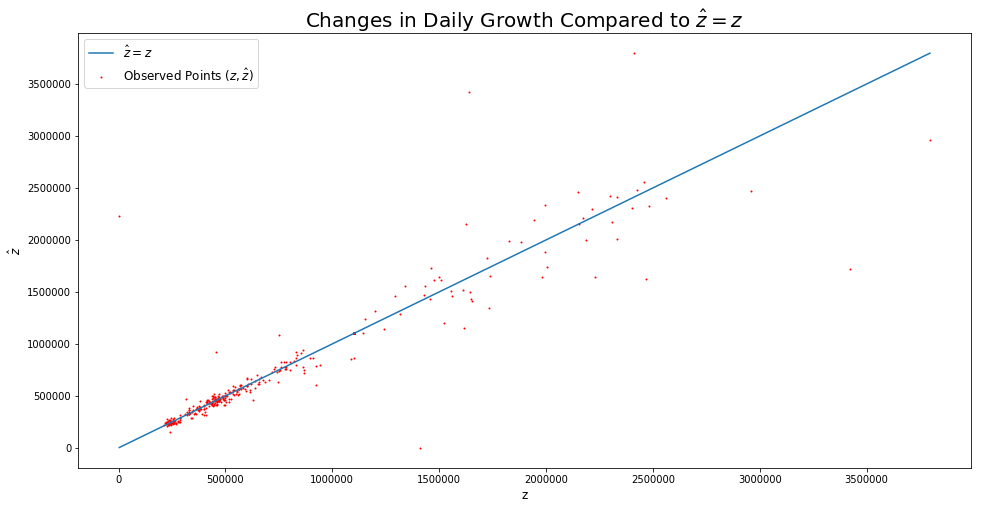

In [6]:
plt.figure(figsize=(16,8))

id = 8

growth = get_view_growth(song_dfs[id]['viewCount'])
growth_df = get_z_hat_df(growth)

line = get_line_method((1, 0))
interval = [f(growth) for f in [min, max]]

# plotting line
plt.plot(interval,
         [line(x) for x in interval],
         label = "$\hat{z}=z$")

# plotting dots
plt.scatter(growth_df['z'],
        growth_df['z_hat'],
        s = 1,
        color = 'red',
        label = "Observed Points $(z, \hat{z})$")

plt.legend(fontsize=12)
plt.title("Changes in Daily Growth Compared to $\hat{z}=z$", fontsize = 20)
plt.xlabel("z", fontsize = 12)
plt.ylabel("$\^{z}$", fontsize = 12)
plt.show()


We then tried to join these data points. We first attempted to use Exponential Smoothing but the results were not satisfying.

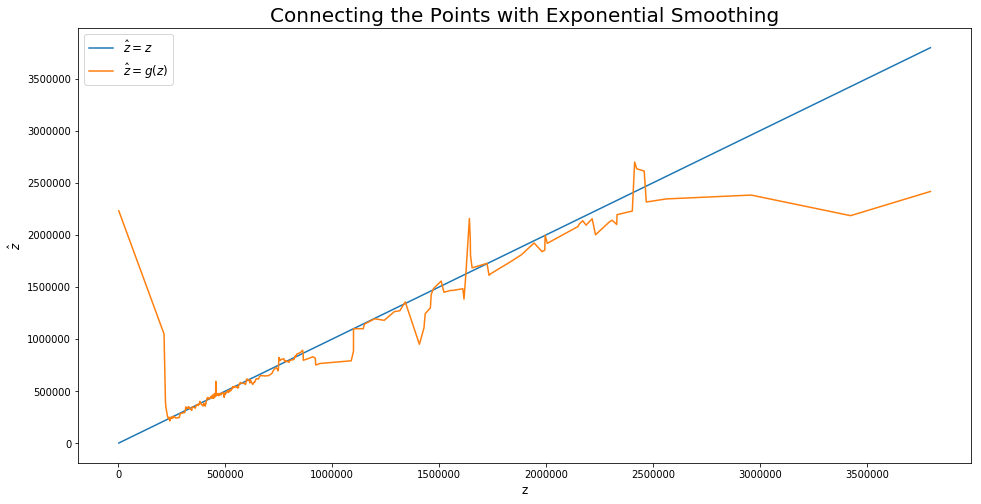

In [7]:
plt.figure(figsize=(16,8))

interval = [f(growth) for f in [min, max]]
plt.plot(interval,
         [line(x) for x in interval],
         label = "$\hat{z}=z$")

# exponential smoothing
growth_df_sorted = growth_df.sort_values(by="z")
plt.plot(growth_df_sorted['z'],
         growth_df_sorted['z_hat'].ewm(alpha=0.3).mean(),
         label = "$\hat{z} = g(z)$")

plt.legend(fontsize=12)
plt.title("Connecting the Points with Exponential Smoothing", fontsize = 20)
plt.xlabel("z", fontsize = 12)
plt.ylabel("$\^{z}$", fontsize = 12)
plt.show()

Then we fitted a cubic polynomial to our points.

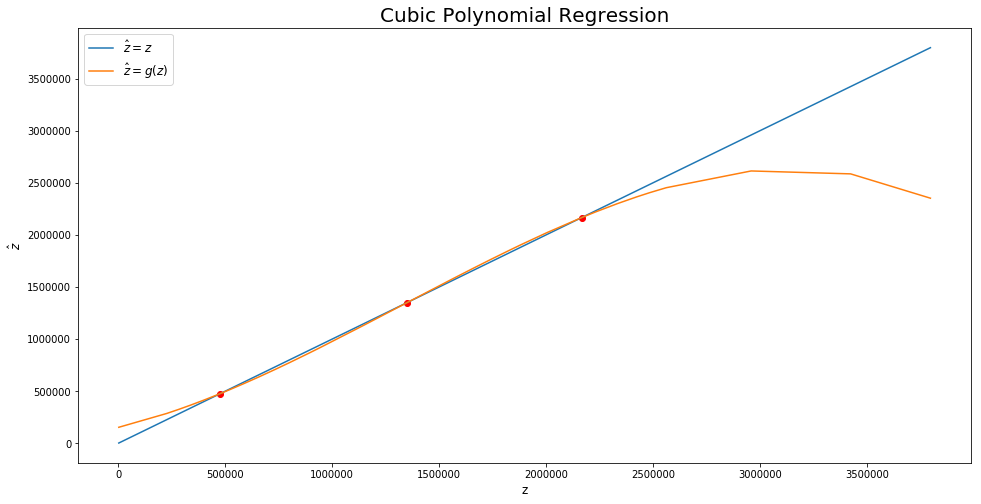

In [8]:
plt.figure(figsize=(16,8))

# plotting the z^=z line
interval = [f(growth) for f in [min, max]]
plt.plot(interval,
         [line(x) for x in interval],
         label = "$\hat{z}=z$")

growth_df_sorted = growth_df.sort_values(by="z")

# fitting a cubic polynomial and plotting it
deg = 3
p = np.polyfit(*[growth_df_sorted[c] for c in ['z', 'z_hat']], deg = deg)
z_hat = apply_p(p, growth_df_sorted['z'])
z_hat[z_hat < 0] = 0
plt.plot(growth_df_sorted['z'],
         z_hat,
         label = "$\hat{z} = g(z)$")

# finding and plotting intersections
p[2] -= 1
roots = np.roots(p)
real_roots = roots[True^np.iscomplex(roots)]
plt.scatter(real_roots, real_roots, color = 'red')

plt.legend(fontsize=12)
plt.title("Cubic Polynomial Regression", fontsize = 20)
plt.xlabel("z", fontsize = 12)
plt.ylabel("$\^{z}$", fontsize = 12)
plt.show()

We were satisfied with the results and we decided to apply the same approach to 4 other songs.

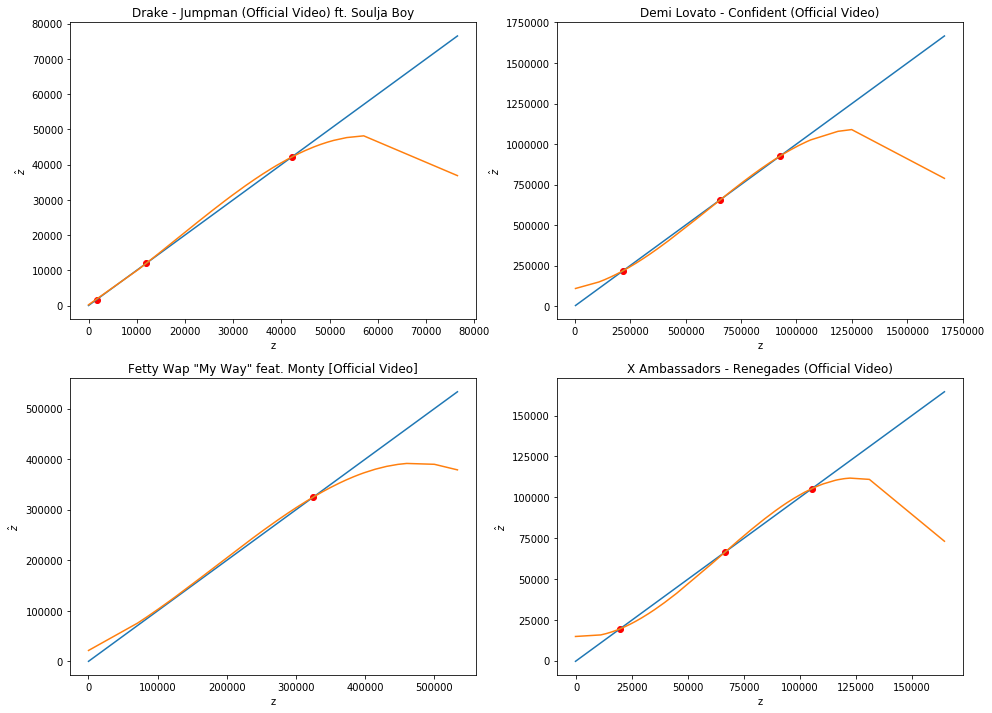

In [9]:
song_ids = [3,9,5,4]
deg = 3

fig, axs = plt.subplots(2,2, figsize = (16,12))

def plot_ax(song_df, ax):

    growth = get_view_growth(song_df['viewCount'])
    growth_df = get_z_hat_df(growth)

    line = get_line_method((1, 0))
    interval = [f(growth) for f in [min, max]]

    # plot line
    ax.plot(interval,
            [line(x) for x in interval],
            label = "$\hat{z}=z$")

    growth_df_sorted = growth_df.sort_values(by="z")
    p = np.polyfit(*[growth_df_sorted[c] for c in ['z', 'z_hat']], deg = deg)
    z_hat = apply_p(p, growth_df_sorted['z'])
    z_hat[z_hat < 0] = 0

    # plot regression
    ax.plot(growth_df_sorted['z'],
            z_hat,
            label = "$\hat{z} = g(z)$")

    # plot intersections
    p[2] -= 1
    roots = np.roots(p)
    real_roots = roots[True^np.iscomplex(roots)]
    ax.scatter(real_roots, real_roots, color = 'red')

    ax.title.set_text(song_df.iloc[0]['songName'])
    ax.set_xlabel("z")
    ax.set_ylabel("$\^{z}$")

for i, song_id in enumerate(song_ids):
    plot_ax(song_dfs[song_id], axs[i//2,i%2])

plt.show()